In [1]:
#Import Standard Dependencies
import cv2
import os
import random
import numpy as np
from matplotlib import pyplot as plt

In [2]:
#Import TensorFlow Dependencies - Functional API
from keras.models import Model
from keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten
import tensorflow as tf 

2023-06-07 10:06:15.674329: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-07 10:06:15.843303: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-06-07 10:06:16.671968: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/student/anaconda3/envs/tensorflow/lib/python3.10/site-packages/cv2/../../lib64:/h

In [3]:
# Setup Paths
POS_PATH = os.path.join("//mnt//c//Users//sit//Desktop//Tejas-SCAAI//Disgust", 'positive')
NEG_PATH = os.path.join("//mnt//c//Users//sit//Desktop//Tejas-SCAAI//Disgust", 'negative')
ANC_PATH = os.path.join("//mnt//c//Users//sit//Desktop//Tejas-SCAAI//Disgust", 'anchor')

In [4]:
anchor = tf.data.Dataset.list_files(ANC_PATH+'/*.jpg')
positive = tf.data.Dataset.list_files(POS_PATH+'/*.jpg')
negative = tf.data.Dataset.list_files(NEG_PATH+'/*.jpg')

2023-06-07 10:06:19.108552: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:2d:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-06-07 10:06:19.126070: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:2d:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-06-07 10:06:19.126192: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:2d:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-06-07 10:06:19.127941: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them i

In [5]:
def preprocess(file_path):
    # read in img from file path
    byte_img = tf.io.read_file(file_path)
    # load in the img
    img = tf.io.decode_jpeg(byte_img)
    # Preprocessing steps - resizing the img to 100x100
    img = tf.image.resize(img, (100,100))
    # scale image between 1 & 0
    img = img/255.0
    return img

In [6]:
positives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = positives.concatenate(negatives)

In [7]:
def preprocess_twin(input_img, validation_img, label):
    return(preprocess(input_img), preprocess(validation_img), label)

In [8]:
# Build dataloader pipeline
data = data.map(preprocess_twin)
data = data.cache()
data = data.shuffle(buffer_size=1000)

In [9]:
# Training Partition 
train_data = data.take(round(len(data)*.7))
train_data = train_data.batch(16)
train_data = train_data.prefetch(8)

In [10]:
# testing Partition
test_data = data.skip(round(len(data)*.7))
test_data = test_data.take(round(len(data)*.3))
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)

In [11]:
round(len(data)*.7)

412

In [12]:
round(len(data)*.3)

176

In [13]:
class L1Dist(Layer):
    def __init__(self, **kwargs):
        super().__init__()
       
    # Magic happens here - similarity calculation
    def call(self, input_embedding, validation_embbedding):
        return tf.math.abs(input_embedding - validation_embbedding)

In [14]:
l1 = L1Dist()

In [15]:
from keras.applications import VGG19
from keras.layers import Input, Flatten, Dense
from keras.models import Model

def make_siamese_model():
    # Anchor image input in the network
    input_image = Input(name='input_img', shape=(100,100,3))
    
    # Validation image input in the network
    validation_image = Input(name='validation_img', shape=(100,100,3))
                             
    # Load pre-trained InceptionResNetV2 model
    base_model = VGG19(weights='imagenet', include_top=False, input_shape=(100,100,3))
    base_model.trainable = False
    # Extract features from the two inputs
    input_features = base_model(input_image)
    validation_features = base_model(validation_image)
    
    # Combine Siamese distance components
    siamese_layer = L1Dist()
    siamese_layer._name = 'distance'
    distances = siamese_layer(input_features, validation_features)
    f1 = Flatten()(distances)
    
    # Classification layer
    classifier = Dense(1, activation='sigmoid')(f1)
    
    return Model(inputs=[input_image, validation_image], outputs = classifier, name='SiameseNetwork')

In [16]:
siamese_model = make_siamese_model()

80134624/80134624 [==============================] - 19s 0us/step


In [17]:
siamese_model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_img (InputLayer)         [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 validation_img (InputLayer)    [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 vgg19 (Functional)             (None, 3, 3, 512)    20024384    ['input_img[0][0]',              
                                                                  'validation_img[0][

**5. Training**

5.1 Setup Loss and Optimizer

In [18]:
binary_cross_loss = tf.losses.BinaryCrossentropy()

In [19]:
opt = tf.keras.optimizers.Adam(1e-4) 

5.2 Establish Checkpoints

In [20]:
checkpoint_dir = './training_checkpoints_disgust_V'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(opt=opt, siamese_model=siamese_model)

5.3 Build Train Step Function

In [21]:
@tf.function
def train_step(batch):
    
    # record all of our operations
    with tf.GradientTape() as tape:
        
        # Get anchor and =ve/-ve img
        X = batch[:2]
        # Get label
        y = batch[2]
        
        # Forward pass
        yhat = siamese_model(X, training=True)
        # Calculate loss
        loss = binary_cross_loss(y,yhat)
        
    # calculate gradients
    grad = tape.gradient(loss, siamese_model.trainable_variables)
    
    # Calculate updated weights and apply to siamese model
    opt.apply_gradients(zip(grad, siamese_model.trainable_variables))
    
    # Return loss
    return loss

5.4 Build Training Loop

In [22]:
from keras.metrics import Precision, Recall

In [27]:
def train(data, EPOCHS):
    # Loop through epochs
    for epoch in range(1, EPOCHS+1):
        print('\n Epoch {}/{}'.format(epoch, EPOCHS))
        progbar = tf.keras.utils.Progbar(len(data))
        
        # Creating a metric object
        r = Recall()
        p = Precision()
        
        # Loop through each batch
        for idx, batch in enumerate(data):
            # Run train step here
            loss = train_step(batch)
            yhat = siamese_model.predict(batch[:2])
            r.update_state(batch[2], yhat)
            p.update_state(batch[2], yhat)
            progbar.update(idx+1)
            
        # Calculate and print training accuracy and loss
        training_acc = (1 - loss) * 100
        print('Training accuracy: {:.2f}%'.format(training_acc))
        print('Training loss: {:.2f}'.format(loss))
            
        # Save checkpoints
        if epoch % 10 == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)
            
        desired_accuracy = 90
       
        if training_acc >= desired_accuracy:
            print('Desired accuracy ({:.2f}%) reached, stopping training'.format(desired_accuracy))
            break


5.5 Train the model

In [31]:
EPOCHS = 50

In [34]:
train(train_data, EPOCHS)


 Epoch 1/50
26/26 [==============================] - 4s 135ms/step
Training accuracy: 73.34%
Training loss: 0.27

 Epoch 2/50
26/26 [==============================] - 4s 137ms/step
Training accuracy: 72.74%
Training loss: 0.27

 Epoch 3/50
26/26 [==============================] - 4s 141ms/step
Training accuracy: 76.11%
Training loss: 0.24

 Epoch 4/50
26/26 [==============================] - 4s 134ms/step
Training accuracy: 85.20%
Training loss: 0.15

 Epoch 5/50
26/26 [==============================] - 3s 133ms/step
Training accuracy: 86.99%
Training loss: 0.13

 Epoch 6/50
26/26 [==============================] - 4s 150ms/step
Training accuracy: 70.00%
Training loss: 0.30

 Epoch 7/50
26/26 [==============================] - 4s 151ms/step
Training accuracy: 76.44%
Training loss: 0.24

 Epoch 8/50
26/26 [==============================] - 4s 154ms/step
Training accuracy: 74.15%
Training loss: 0.26

 Epoch 9/50
26/26 [==============================] - 4s 143ms/step
Training accuracy: 8

**6. Evaluate the Model**

6.1 Import Metrics

In [35]:
# Import metric calculations
from tensorflow.keras.metrics import Precision,Recall

6.2 Make Predictions

1/1 [==============================] - 0s 39ms/step


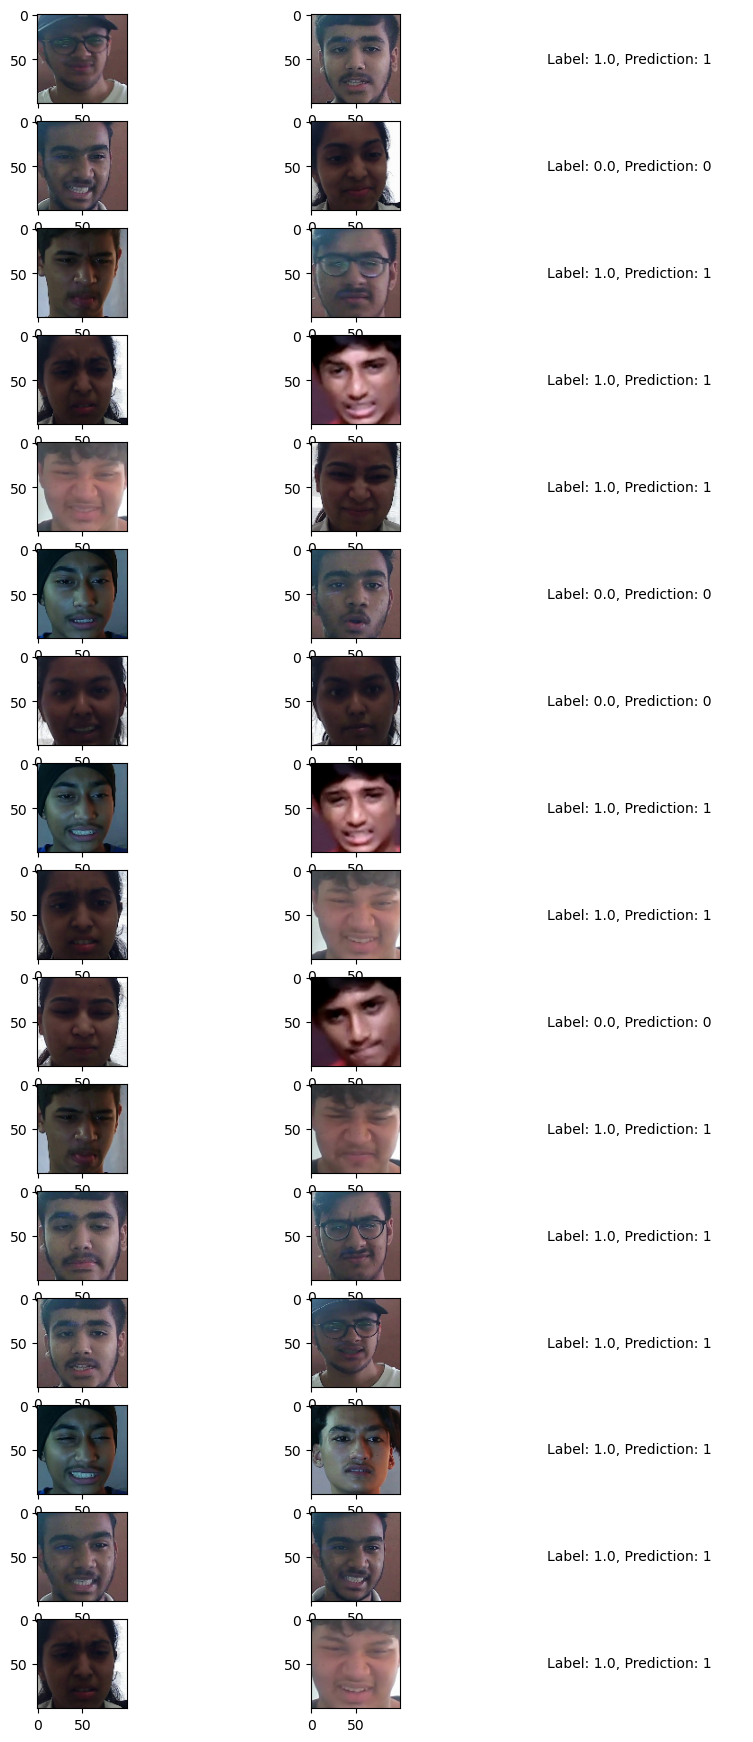

In [36]:
# Get the next batch of data from the test data
test_input, test_val, y_true = test_data.as_numpy_iterator().next()

# Make predictions for the batch
y_hat = siamese_model.predict([test_input, test_val])
# Convert predictions to binary labels
y_hat = [1 if prediction > 0.5 else 0 for prediction in y_hat]

# Create a figure with the number of rows equal to the batch size
fig, axes = plt.subplots(len(test_input), 3, figsize=(10, 22))

# Iterate over the images in the batch
for i in range(len(test_input)):
  # Display the images in the first column of the figure
  axes[i, 0].imshow(test_input[i])
  axes[i, 1].imshow(test_val[i])
  #axes[i, 0].imshow(test_input[i][:, :, 0],cmap='gray')
  #axes[i, 1].imshow(test_val[i][:, :, 0], cmap='gray')
  
  # Display the labels and predictions in the third column of the figure
  #axes[i, 2].set_title("Label: {}, Prediction: {}".format(y_true[i], y_hat[i]))
  text = "Label: {}, Prediction: {}".format(y_true[i], y_hat[i])  
  axes[i, 2].text(0.5, 0.5, text, va='center', ha='center')  
  axes[i, 2].set_xticks([])
  axes[i, 2].set_yticks([])
  for spine in axes[i, 2].spines.values():
      spine.set_visible(False)

# Show the figure
plt.show()


In [37]:
# Get a batch of test data 
test_input, test_val, y_true = test_data.as_numpy_iterator().next()

In [38]:
# Make predictions
y_hat = siamese_model.predict([test_input, test_val])
y_hat

1/1 [==============================] - 0s 51ms/step


array([[0.73914886],
       [0.40007195],
       [0.9775689 ],
       [0.25727683],
       [0.07000662],
       [0.15710509],
       [0.19547823],
       [0.23598862],
       [0.903828  ],
       [0.78452843],
       [0.7275336 ],
       [0.7384797 ],
       [0.8144939 ],
       [0.01153122],
       [0.9263147 ],
       [0.40768325]], dtype=float32)

In [39]:
# Post processing the results
[1 if prediction > 0.5 else 0 for prediction in y_hat]

[1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0]

In [40]:
y_true

array([1., 0., 1., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 0., 1., 0.],
      dtype=float32)

6.3 Calculating Metrics

In [41]:
# Initialize variables for storing results
total_accuracy = 0
total_precision = 0
total_recall = 0
total_f1 = 0
num_batches = 0

# Iterate over the test data
for test_input, test_val, y_true in test_data.as_numpy_iterator():
  # Make predictions
  y_hat = siamese_model.predict([test_input, test_val])
  # Convert predictions to binary labels
  y_hat = [1 if prediction > 0.5 else 0 for prediction in y_hat]
  
  # Calculate accuracy
  accuracy = tf.keras.metrics.Accuracy()
  accuracy.update_state(y_true, y_hat)
  total_accuracy += accuracy.result().numpy()
  
  # Calculate precision
  precision = tf.keras.metrics.Precision()
  precision.update_state(y_true, y_hat)
  total_precision += precision.result().numpy()
  
  # Calculate recall
  recall = tf.keras.metrics.Recall()
  recall.update_state(y_true, y_hat)
  total_recall += recall.result().numpy()
  
  # Calculate F1 score
  f1 = 2 * (precision.result() * recall.result()) / (precision.result() + recall.result())
  total_f1 += f1.numpy()
  
  num_batches += 1
  
# Calculate average test accuracy, precision, recall, and F1 score
avg_accuracy = total_accuracy / num_batches
avg_precision = total_precision / num_batches
avg_recall = total_recall / num_batches
avg_f1 = total_f1 / num_batches

# Print results
print("Test accuracy:", avg_accuracy)
print("Test precision:", avg_precision)
print("Test recall:", avg_recall)
print("Test F1 score:", avg_f1)


1/1 [==============================] - 0s 67ms/step
Test accuracy: 0.9886363636363636
Test precision: 0.9614325111562555
Test recall: 1.0
Test F1 score: 0.9774891788309271


**7. Save Model**

In [42]:
# Save weights
siamese_model.save("Author's_Teen_VGG_Disgust.h5")